#Predicting Text Sentimental Analysis with BERT
## Technique: Bert-Keras
## Model: Softmax
## Data: Sentiment140


General Concept:


*   https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html
*   https://github.com/google-research/bert



In [ ]:
%tensorflow_version 1.x
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from tensorflow import keras
import os
import re
import numpy as np

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

Loading bert-tensorflow library


*   https://pypi.org/project/bert-tensorflow/
*   https://github.com/google-research/bert



In [ ]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 6.4MB/s 


In [ ]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Save model to Google Cloud Storage: https://github.com/google-research/bert/blob/0a0ea64a3ac1f43ed27d75278b9578708f9febcf/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

In [ ]:
# OUTPUT_DIR = 'output_bert_softmax_sentiment140'
# DO_DELETE = False
# USE_BUCKET = True
# BUCKET = 'bert-finetune-kobkrit'
# if USE_BUCKET:
#   OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
#   from google.colab import auth
#   auth.authenticate_user()

# if DO_DELETE:
#   try:
#     tf.gfile.DeleteRecursively(OUTPUT_DIR)
#   except:
#     # Doesn't matter if the directory didn't exist
#     pass
# tf.gfile.MakeDirs(OUTPUT_DIR)
# print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


#Data

## Sentiment140


Original Sentiment140 Dataset Download: https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit




In [ ]:
!gdown --id "0B04GJPshIjmPRnZManQwWEdTZjg"

Downloading...
From: https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg
To: /content/trainingandtestdata.zip
81.4MB [00:00, 99.8MB/s]


In [ ]:
!unzip trainingandtestdata.zip
!ls

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  
sample_data			training.1600000.processed.noemoticon.csv
testdata.manual.2009.06.14.csv	trainingandtestdata.zip


In [ ]:
all_df = pd.read_csv("./training.1600000.processed.noemoticon.csv", encoding="latin-1")
train = all_df.sample(100000)
test = all_df.sample(10000)

In [ ]:
train.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1582738,4,2190350327,Tue Jun 16 02:28:45 PDT 2009,NO_QUERY,KatyCaptivated,Franz Ferdinand - No you Girls...great song.
1422420,4,2058484312,Sat Jun 06 15:02:04 PDT 2009,NO_QUERY,AbbieFletcher_,@samjmoody everyone is saying that they are in...
136069,0,1880023562,Thu May 21 23:51:43 PDT 2009,NO_QUERY,Fluffy_Cupycake,@chris_slater seriously.. i was sitting here w...
573617,0,2209940985,Wed Jun 17 10:58:57 PDT 2009,NO_QUERY,lisacat,"@PRsarahevans Yes, losing an iPhone is crummy ..."
674253,0,2247733795,Fri Jun 19 19:32:31 PDT 2009,NO_QUERY,GenMac,"on the floor with Goblin, Zil and me. Not sure..."


In [ ]:
train.shape

(100000, 6)

In [ ]:
test.shape

(10000, 6)

In [ ]:
test

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
952842,4,1824526548,Sun May 17 01:45:59 PDT 2009,NO_QUERY,flahlah,live long &amp; prosper
202232,0,1972076421,Sat May 30 08:30:39 PDT 2009,NO_QUERY,TCFS,do you know whats not cool? going to drinks th...
1299735,4,2006301750,Tue Jun 02 10:57:59 PDT 2009,NO_QUERY,mnwin,@michaelcavitt Smart thinking! I decided to k...
1308729,4,2012896551,Tue Jun 02 21:30:07 PDT 2009,NO_QUERY,Brywv,Just love weddings
1364818,4,2049839877,Fri Jun 05 17:35:36 PDT 2009,NO_QUERY,geee_geee,Making myself a grilled cheese sandwich.. quic...
...,...,...,...,...,...,...
727080,0,2262740871,Sat Jun 20 23:08:03 PDT 2009,NO_QUERY,bookie_17_87,Tonight was awful fighting with the bf and bab...
911925,4,1752123392,Sat May 09 21:06:20 PDT 2009,NO_QUERY,sippinslow,"ang payat ko na, yes! hoping to go down to my ..."
69773,0,1693423420,Sun May 03 22:30:16 PDT 2009,NO_QUERY,DrManhattan_,Those heady times we shared - I miss you alrea...
1171106,4,1980455739,Sun May 31 06:47:45 PDT 2009,NO_QUERY,mandyyjiroux,@kaseypoole thank u ! it means a lot


From: https://www.kaggle.com/kazanova/sentiment140

The data is a CSV with emoticons removed. Data file format has 6 fields:
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query (lyx). If there is no query, then this value is NO_QUERY.
4 - the user that tweeted (robotickilldozr)
5 - the text of the tweet (Lyx is cool)


In [ ]:
# clean data
test.columns = train.columns = all_df.columns = ['sentiment','id','date','query','userid','text']


In [ ]:
train.columns

Index(['sentiment', 'id', 'date', 'query', 'userid', 'text'], dtype='object')

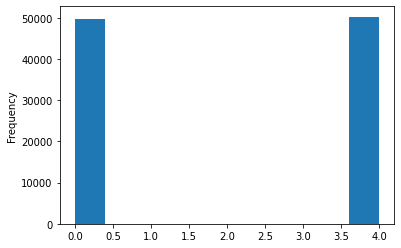

In [ ]:
# class + = 50000, class - = 50000
train['sentiment'].plot(kind='hist')

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

train['sentiment'] = train.sentiment.astype(int)
test['sentiment'] = test.sentiment.astype(int)

# the polarity of the tweet (0 = negative,4 = positive)
# the polarity of the tweet (0 = negative,1 = positive)
# positive is 1 negative is 0
train.loc[train.sentiment > 0, 'sentiment'] = 1
test.loc[test.sentiment > 0, 'sentiment'] = 1

label_list = [0, 1]

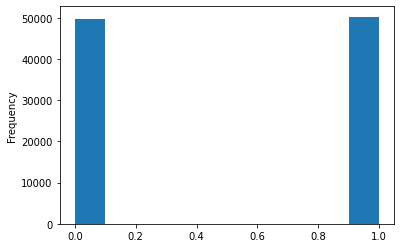

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

train['sentiment'].plot(kind='hist')

#Data Preprocessing

From: https://github.com/google-research/bert/blob/0a0ea64a3ac1f43ed27d75278b9578708f9febcf/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe.
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [ ]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
# convert text to InputExample that generate bert embedding to prepare for each layers
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN],
                                                                   text_b = None,
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN],
                                                                   text_b = None,
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
# load model and use tenserflowhub model
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

# BERT Keras Model

To start with LSTM, we'll need create our own Keras BERT Layer
https://github.com/strongio/keras-bert/



In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers


In [ ]:
# bert layer that we can use for our keras
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)


In [ ]:
def build_model(max_seq_length):
    # input id, masks, seqment
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    # get bert input by input id, masks, seqment
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=1, pooling="first")(bert_inputs)
    # Option A.
    # dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)

    # Option B.
    # reshape = tf.keras.layers.Reshape((1,768), input_shape=(None,768))(bert_output)
    # lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(1, 768)))(reshape)

    pred = tf.keras.layers.Dense(2, activation='softmax')(bert_output)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    model.summary()

    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
train_input_ids = []
train_input_masks = []
train_segment_ids = []
train_label_ids = []

for i in range(len(train_features)):
  train_input_ids.append(train_features[i].input_ids)
  train_input_masks.append(train_features[i].input_mask)
  train_segment_ids.append(train_features[i].segment_ids)
  train_label_ids.append(train_features[i].label_id)

test_input_ids = []
test_input_masks = []
test_segment_ids = []
test_label_ids = []

for i in range(len(test_features)):
  test_input_ids.append(test_features[i].input_ids)
  test_input_masks.append(test_features[i].input_mask)
  test_segment_ids.append(test_features[i].segment_ids)
  test_label_ids.append(test_features[i].label_id)


In [ ]:
# Initialize session
sess = tf.Session()

# Load Model

In [ ]:
# # Clear and load model
# model = None
# model = build_model(MAX_SEQ_LENGTH)
# initialize_vars(sess)

# tf.gfile.Copy(
#      OUTPUT_DIR+"/BertLSTM.h5",
#     "BertLSTM.h5",
#     overwrite=True
# )
# model.load_weights('BertLSTM.h5')

# Train Model (Optional)

In [ ]:
model = build_model(MAX_SEQ_LENGTH)

# Instantiate variables
initialize_vars(sess)

In [ ]:
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids],
    train_label_ids,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_label_ids),
    epochs=1,
    batch_size=32
)

In [ ]:
# model.save('BertLSTM.h5')
# tf.gfile.Copy(
#     "BertLSTM.h5",
#     OUTPUT_DIR+"/BertLSTM.h5",
#     overwrite=True
# )

# Test set prediction  

In [ ]:
predictions = model.predict([test_input_ids,
                            test_input_masks,
                            test_segment_ids]
                           )


In [ ]:
predictions

In [ ]:
labels = ["Negative", "Positive"]
results = [(sentence, prediction, labels[np.argmax(prediction)]) for sentence, prediction in zip(test[DATA_COLUMN], predictions)]

In [ ]:
results

In [ ]:
labels = [x[2] for x in results]
plt.hist(labels)

# Prediction on Input Sentence


Now let's write code to make predictions on new sentences:
cite: https://github.com/google-research/bert/issues/322

In [ ]:
pred_sentences = [
  "Microsft lost a trillion of dollar, People hate this",
  "Saudis Race to Restore Oil Output After Aramco Attacks",
  "Trump Defends Brett Kavanaugh After New Revelations",
  "Google got double the profit"
]

In [ ]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]

  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_input_ids = []
  input_input_masks = []
  input_segment_ids = []

  for i in range(len(input_features)):
    input_input_ids.append(input_features[i].input_ids)
    input_input_masks.append(input_features[i].input_mask)
    input_segment_ids.append(input_features[i].segment_ids)

  predictions = model.predict([input_input_ids,
                            input_input_masks,
                            input_segment_ids]
                           )

  return [(sentence, prediction, labels[np.argmax(prediction)]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
predictions = getPrediction(pred_sentences)

Voila! We have a sentiment classifier!

In [ ]:
predictions